<H1 align="middle">Long Short-Term Memory for Membership Inference Attack on AAF Data</H1>

<br>
<strong>This notebook performs a long short-term memory-based membership inference attack on the AAF data with set hyperparameters.</strong>

## Import Libraries

### Python Libraries

In [1]:
from datetime import datetime

### External Libraries

In [2]:
import torch
import torch.nn as nn

### Custom Libraries

In [3]:
from src.utils_random import set_random_seed
from src.utils_torch.data import stratified_random_split
from src.utils_attacker_lstm.data import DatasetAttackerLSTMAAF, DataLoaderAttackerLSTM
from src.utils_attacker_lstm.models import ModelAttackerLSTM, TrainerAttackerLSTM, TesterAttackerLSTM, \
    ManagerAttackerLSTM
from src.utils_plot import plot_train_eval_loss_accuracy, plot_receiver_operating_characteristics_curve, \
    plot_confusion_matrix, plot_long_short_term_memory

## Set Parameters

### Model Id

In [4]:
model_id = "9999999"

In [6]:
random_seed = 0

### Data Params

In [7]:
num_snps = 80000
train_eval_test_split = [0.7, 0.15, 0.15]

### Loader Params

In [8]:
genome_batch_size = 32
snp_batch_size = 80000

### Model Params

#### Conv1d Params

In [9]:
conv_num_layers = 3
conv_channel_size = [3, 16, 32, 16]
conv_kernel_size = [20, 10, 10]
conv_stride = [2, 2, 2]
conv_dilation = [1, 1, 1]
conv_groups = [1, 1, 1]

conv_activation = [nn.ReLU, nn.ReLU]
conv_activation_kwargs = [{}, {}]

conv_dropout_p = [0.5, 0.5]
conv_dropout_first = [True, True]

conv_batch_norm = [True, True]
conv_batch_norm_momentum = [0.1, 0.1]

#### Conv1d to LSTM Params

In [10]:
conv_lstm_activation = nn.ReLU
conv_lstm_activation_kwargs = {}
conv_lstm_dropout_p = 0.5
conv_lstm_dropout_first = True
conv_lstm_layer_norm = True

#### LSTM Params

In [11]:
lstm_num_layers = 1
lstm_input_size = 16
lstm_hidden_size = [32]
lstm_proj_size = [0]
lstm_bidirectional = [True]

lstm_dropout_p = []
lstm_dropout_first = []

lstm_layer_norm = []

#### LSTM to Linear Params

In [12]:
lstm_linear_dropout_p = 0.5
lstm_linear_dropout_first = True

lstm_linear_batch_norm = True
lstm_linear_batch_norm_momentum = 0.1

#### Linear Params

In [13]:
linear_num_layers = 1
linear_num_features = [64, 1]

linear_activation = []
linear_activation_kwargs = []

linear_dropout_p = []
linear_dropout_first = []

linear_batch_norm = []
linear_batch_norm_momentum = []

### Trainer Params

In [14]:
num_epochs = 256
learning_rate = 0.001

### IO Params

In [15]:
models_dir = "../models"
models_file = "models.csv"
plots_dir = "../plots"

## Set Torch Device

In [16]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Set Random Seed

In [17]:
set_random_seed(random_seed)

## Create Dataset

In [18]:
dataset = DatasetAttackerLSTMAAF(genomes_pool_path="../data/test/In_Pop.pkl",
                                 genomes_reference_path="../data/test/Not_In_Pop.pkl",
                                 num_snps=num_snps)
subset_train, subset_eval, subset_test = stratified_random_split(dataset, train_eval_test_split)

## Create DataLoaders

In [19]:
dataloader_train = DataLoaderAttackerLSTM(dataset=subset_train,
                                          genome_batch_size=genome_batch_size,
                                          snp_batch_size=snp_batch_size,
                                          shuffle=True)
dataloader_eval = DataLoaderAttackerLSTM(dataset=subset_eval,
                                         genome_batch_size=genome_batch_size,
                                         snp_batch_size=snp_batch_size,
                                         shuffle=False)
dataloader_test = DataLoaderAttackerLSTM(dataset=subset_test,
                                         genome_batch_size=genome_batch_size,
                                         snp_batch_size=snp_batch_size,
                                         shuffle=False)

## Create Model

In [20]:
model = ModelAttackerLSTM(conv_num_layers=conv_num_layers,
                          conv_channel_size=conv_channel_size,
                          conv_kernel_size=conv_kernel_size,
                          conv_stride=conv_stride,
                          conv_dilation=conv_dilation,
                          conv_groups=conv_groups,
                          conv_activation=conv_activation,
                          conv_activation_kwargs=conv_activation_kwargs,
                          conv_dropout_p=conv_dropout_p,
                          conv_dropout_first=conv_dropout_first,
                          conv_batch_norm=conv_batch_norm,
                          conv_batch_norm_momentum=conv_batch_norm_momentum,
                          conv_lstm_activation=conv_lstm_activation,
                          conv_lstm_activation_kwargs=conv_lstm_activation_kwargs,
                          conv_lstm_dropout_p=conv_lstm_dropout_p,
                          conv_lstm_dropout_first=conv_lstm_dropout_first,
                          conv_lstm_layer_norm=conv_lstm_layer_norm,
                          lstm_num_layers=lstm_num_layers,
                          lstm_input_size=lstm_input_size,
                          lstm_hidden_size=lstm_hidden_size,
                          lstm_proj_size=lstm_proj_size,
                          lstm_bidirectional=lstm_bidirectional,
                          lstm_dropout_p=lstm_dropout_p,
                          lstm_dropout_first=lstm_dropout_first,
                          lstm_layer_norm=lstm_layer_norm,
                          lstm_linear_dropout_p=lstm_linear_dropout_p,
                          lstm_linear_dropout_first=lstm_linear_dropout_first,
                          lstm_linear_batch_norm=lstm_linear_batch_norm,
                          lstm_linear_batch_norm_momentum=lstm_linear_batch_norm_momentum,
                          linear_num_layers=linear_num_layers,
                          linear_num_features=linear_num_features,
                          linear_activation=linear_activation,
                          linear_activation_kwargs=linear_activation_kwargs,
                          linear_dropout_p=linear_dropout_p,
                          linear_dropout_first=linear_dropout_first,
                          linear_batch_norm=linear_batch_norm,
                          linear_batch_norm_momentum=linear_batch_norm_momentum)
model.to(device)

ModelAttackerConvLSTMLinear(
  (lstm_modules): MultiLayerLSTM(
    (_lstm_modules): ModuleList(
      (0): LSTM(16, 32, batch_first=True, bidirectional=True)
    )
    (_dropout_modules): ModuleList()
    (_layer_norm_modules): ModuleList()
  )
  (lstm_linear_dropout_module): Dropout(p=0.25, inplace=False)
  (lstm_linear_batch_norm_module): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_modules): MultiLayerLinear(
    (_multi_layer_modules): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (conv_modules): MultiLayerConv1d(
    (_multi_layer_modules): Sequential(
      (0): Conv1d(3, 16, kernel_size=(20,), stride=(2,))
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Conv1d(16, 32, kernel_size=(10,), stride=(2,))
      (5): ReLU()
      (6): Dropout(p=0.5, inplace=False)
      (7): BatchNorm1d(32, e

## Create Trainer

### Create Criterion and Optimizer

In [21]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=learning_rate)
scheduler = None

### Create Trainer

In [22]:
trainer = TrainerAttackerLSTM(model=model,
                              criterion=criterion,
                              optimizer=optimizer,
                              scheduler=scheduler,
                              train_loader=dataloader_train,
                              eval_loader=dataloader_eval,
                              device=device,
                              max_grad_norm=1.0,
                              norm_type=2)

## Create Tester

In [23]:
tester = TesterAttackerLSTM(model=model,
                            criterion=criterion,
                            test_loader=dataloader_test,
                            device=device)

## Create Manager

In [82]:
manager = ManagerAttackerLSTM(models_dir=models_dir,
                              models_file=models_file)

## Train Model

### Train Model

In [24]:
trainer.train(num_epochs=num_epochs, verbose=True)

Epoch 1/256
Train Loss: 0.7374, Train Accuracy: 0.48
Evaluation Loss: 0.6945, Evaluation Accuracy: 0.51
Evaluation Loss Decreased: inf -> 0.6945. Saving Model...
Epoch 2/256
Train Loss: 0.7442, Train Accuracy: 0.48
Evaluation Loss: 0.6942, Evaluation Accuracy: 0.53
Evaluation Loss Decreased: 0.6945 -> 0.6942. Saving Model...
Epoch 3/256
Train Loss: 0.7210, Train Accuracy: 0.49
Evaluation Loss: 0.6923, Evaluation Accuracy: 0.57
Evaluation Loss Decreased: 0.6942 -> 0.6923. Saving Model...
Epoch 4/256
Train Loss: 0.7194, Train Accuracy: 0.49
Evaluation Loss: 0.7006, Evaluation Accuracy: 0.48
Epoch 5/256
Train Loss: 0.6950, Train Accuracy: 0.54
Evaluation Loss: 0.7010, Evaluation Accuracy: 0.47
Epoch 6/256
Train Loss: 0.7105, Train Accuracy: 0.50
Evaluation Loss: 0.7019, Evaluation Accuracy: 0.44
Epoch 7/256
Train Loss: 0.7136, Train Accuracy: 0.49
Evaluation Loss: 0.7038, Evaluation Accuracy: 0.47
Epoch 8/256
Train Loss: 0.7179, Train Accuracy: 0.49
Evaluation Loss: 0.7036, Evaluation Acc

### Print Metrics

In [25]:
finish_time = datetime.now()
best_eval_loss_epoch = trainer.best_eval_loss_epoch
best_eval_loss = trainer.best_eval_loss
best_eval_accuracy = trainer.eval_accuracies[best_eval_loss_epoch]

print(f'Finished training at {finish_time}')
print(f'Best evaluation loss epoch found at: {best_eval_loss_epoch}')
print(f'Best evaluation loss found: {best_eval_loss:.4f}')
print(f'Best evaluation accuracy found: {best_eval_accuracy:.4f}')

Finished training at 2024-12-06 09:45:37.365170
Best evaluation loss epoch found at: 2
Best evaluation loss found: 0.6923
Best evaluation accuracy found: 0.5750


### Plot Metrics

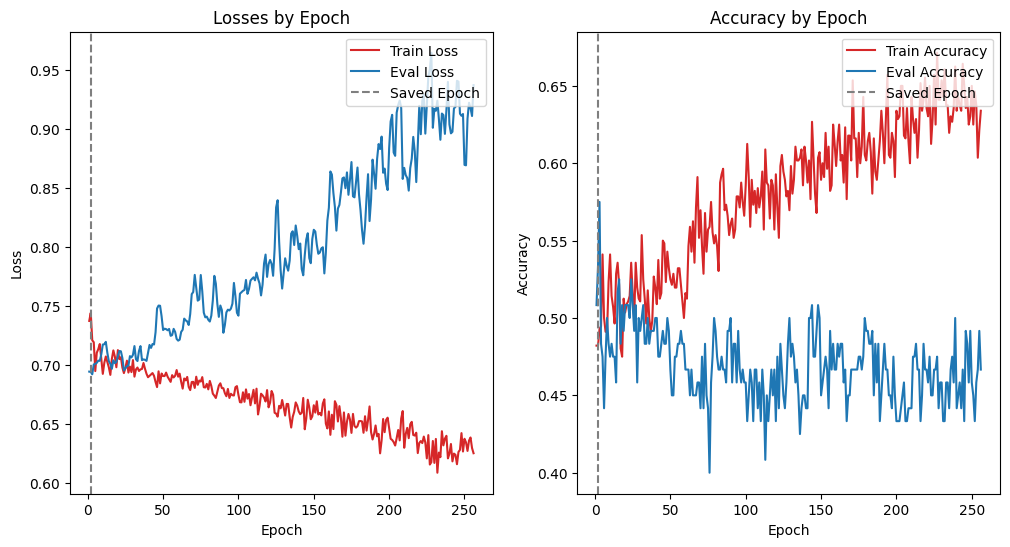

In [26]:
plot_train_eval_loss_accuracy(train_loss=trainer.train_losses,
                              train_accuracy=trainer.train_accuracies,
                              eval_loss=trainer.eval_losses,
                              eval_accuracy=trainer.eval_accuracies,
                              saved_epoch=best_eval_loss_epoch,
                              output_path=plots_dir,
                              output_file=f"model_attacker_pool_{model_id}_train_eval_loss_acc.png")

## Test Model

### Test Model

In [27]:
tester.test()

### Print Metrics

In [28]:
print(f'Test loss: {tester.loss:.4f}')
print(f'Test accuracy: {tester.accuracy_score:.2f}')
print(f'Test precision: {tester.precision_score:.2f}')
print(f'Test recall: {tester.recall_score:.2f}')
print(f'Test f1: {tester.f1_score:.2f}')
print(f'Test AUC: {tester.auroc_score:.2f}')

Test loss: 0.6872
Test accuracy: 0.60
Test precision: 0.57
Test recall: 0.80
Test f1: 0.67
Test AUC: 0.60


### Plot ROC Curve

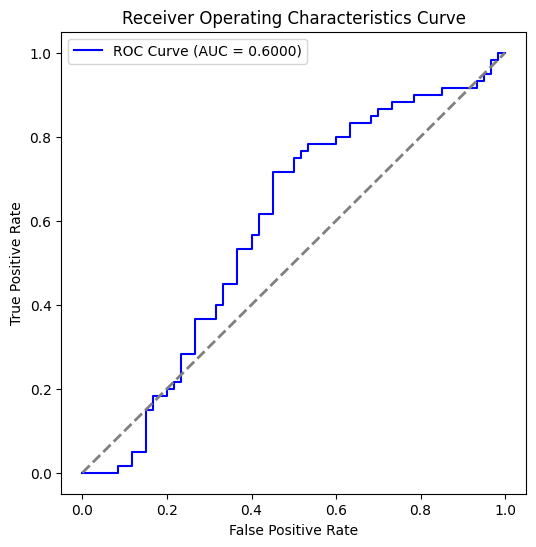

In [29]:
fpr, tpr, _ = tester.roc_curve
plot_receiver_operating_characteristics_curve(false_positive_rates=fpr,
                                              true_positive_rates=tpr,
                                              auc=tester.auroc_score,
                                              output_path=plots_dir,
                                              output_file=f"model_attacker_pool_{model_id}_roc_curve.png")

### Plot Confusion Matrix

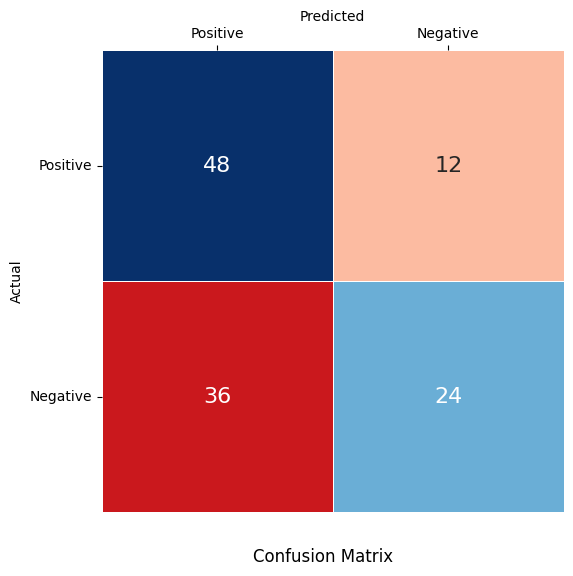

In [30]:
plot_confusion_matrix(confusion_matrix=tester.confusion_matrix_scores,
                      task="binary",
                      output_path=plots_dir,
                      output_file=f"model_attacker_pool_{model_id}_confusion_matrix.png")

## Save Model


In [90]:
manager.add_model(model_id=model_id,
                  random_seed=random_seed,
                  data=dataset,
                  loader=dataloader_train,
                  model=model,
                  trainer=trainer,
                  tester=tester)

## Plot Memory

In [91]:
model.set_hidden_cell_mode(True)
model.eval()
with torch.no_grad():
    x, y = dataloader_test.dataset[0]
    x = x.unsqueeze(0).to(device)
    hx = None
    logits, out = model.forward(x, hx)
out_last = out[-1]
(h, c), (h_last, c_last) = out_last
h, c = h.squeeze(0), c.squeeze(0)

C:\Users\Zhou\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:878: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


In [92]:
plot_long_short_term_memory(long_term_memory=c.cpu(),
                            short_term_memory=h.cpu(),
                            bidirectional=lstm_bidirectional[-1],
                            output_path=plots_dir,
                            output_file=f"model_attacker_pool_{model_id}_lstm.png",
                            show=False)